# ARIM情報活用講座：　ケモインフォマテックス 編　
# 第４回：　類似度計算と次元削減

## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第一章　データに慣れよう


## データセット
実践例として用いるdelaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいており、ケモインフォマテックス分野では広く知られているデータセットです。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記


## pythonライブラリ


**NumPy**：　高性能の数値計算やデータ処理に特化したPythonのライブラリです。NumPyは多次元の配列や行列を効率的に操作する機能を提供し、科学技術計算やデータ解析の分野で広く使用されています。

**Pandas**：　データ操作と解析のための高レベルのPythonライブラリです。Pandasは、テーブル形式のデータを効率的に処理し、データのフィルタリング、変換、集約、および結合などの機能を提供します。データの整形やクリーニング、欠損値の処理などを容易に行うことができます。

**Matplotlib**：　Pythonでデータを可視化するための強力なライブラリです。Matplotlibは、グラフや図を描画するための多様な機能を提供し、折れ線グラフ、ヒストグラム、散布図、バーチャートなどの多くのプロットスタイルをサポートしています。データの傾向や関係性を視覚的に理解するための強力なツールです。

**RDKit**：　RDKitは、化学情報学や薬学の分野で広く使用されるオープンソースのソフトウェア開発キットです。RDKitはPythonで実装されており、様々な化学情報の処理や分子の構造解析、化学反応の予測などをサポートします。

## 目標
RDKitを使って分子記述子の扱い方と、その記述子から分子構造と性能の類似度の相関性をPCAやt-SNEで可視化するフローを示します。
* 記述子としてRDKit記述子の操作のほか、MorganのFingerpringについて計算する方法を学びます。
* 可視化には次元削減の一つの手法であるt-SNEを用い、構造の類似性のタニモト係数を次元圧縮させた空間に水溶解度を付置させて相関性を可視化します。

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [41]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Training/Training_python_4.git
%cd Training_python_4

C:\Users\Matsunami\Dropbox\9_GitHub_python\ARIM_python_4_マテリアルインフォマティックス\Training_python_4


fatal: destination path 'Training_python_4' already exists and is not an empty directory.


## 1.分子構造データの読み込み　（P.11）

### 汎用ライブラリのインポート

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み
ここでは「data/delaney-solubility」フォルダーにあるdelaney-processed.csvをpandasの`read_csv()`からデータフレーム（DataFrame）オブジェクトとして変数dfに格納します。dfは1128化合物に対して10の特徴量からなるデータ行列となっていることが確かめられます。

In [2]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df['mol']=df['smiles'].apply(MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x0000021CA5E...


ここで特に着目する特徴量はlog水溶解度の予測値（ESOL predicted log solubility in mols per litre）と実験値（measured log solubility in mols per litre）との相関となります。ここでは相関図とヒストグラムの二通りの可視化方法で出力をしてみましょう。

下記の可視化図はandersle.noのブログにある https://www.andersle.no/posts/2022/esol/esol.html　を参照しています。

## 2.分子記述子の計算
### RDKit記述子
RDKit記述子の`descList`メソッドより、分子量やフラグメントなどの209の項目（情報）についてみてみることにしましょう。

In [3]:
from rdkit.Chem.Descriptors import descList

In [4]:
# 化合物IDの最初のアミグダリンについての記述子とその値
mol = df['mol'][0]

for descriptor in descList:
    value = descriptor[1](mol)
    print(descriptor[0], value)

MaxAbsEStateIndex 10.253328884035504
MaxEStateIndex 10.253328884035504
MinAbsEStateIndex 0.48660209297610146
MinEStateIndex -1.7016049382716056
qed 0.21751778620947723
MolWt 457.4320000000001
HeavyAtomMolWt 430.21600000000024
ExactMolWt 457.1584106839999
NumValenceElectrons 178
NumRadicalElectrons 0
MaxPartialCharge 0.1882658561787514
MinPartialCharge -0.3935665150995826
MaxAbsPartialCharge 0.3935665150995826
MinAbsPartialCharge 0.1882658561787514
FpDensityMorgan1 0.8125
FpDensityMorgan2 1.375
FpDensityMorgan3 1.96875
BCUT2D_MWHI 16.732837958750792
BCUT2D_MWLOW 9.98056032659302
BCUT2D_CHGHI 2.4752382296424558
BCUT2D_CHGLO -2.425091864223853
BCUT2D_LOGPHI 2.284935450528444
BCUT2D_LOGPLOW -2.613925609105604
BCUT2D_MRHI 5.2166929007512515
BCUT2D_MRLOW -0.33372920506026804
AvgIpc 2.81312867812016
BalabanJ 1.6549374848621088
BertzCT 759.6629378441625
Chi0 23.413484604514085
Chi0n 16.862519795262227
Chi0v 16.862519795262227
Chi1 15.277294663077214
Chi1n 9.998815978920186
Chi1v 9.998815978920

### 1128化合物の記述子の計算

辞書型の`values()`関数を使ってキーに格納されている値をdescValues変数（オブジェクト）に配置します。

In [5]:
# ディスクリプタ（記述子）の値についてのオブジェクト
descValues = dict(descList).values()

1128の化合物に対しての記述子の値を取得し、fng_valのリストに格納します。

In [6]:
# 結果を格納するリストを初期化する
fng_val = []

# ラムダ関数を定義する
lambda_func = lambda f: f(m)

# リストの各要素に対して処理を行う
for m in df['mol']:
    #  DataFrameの列'mol'の各要素に対して繰り返す
    #  ラムダ関数を適用し、結果をリストに追加する
    result = list(map(lambda_func, descValues))
    fng_val.append(result)

In [7]:
# 1128化合物×209個のarray
#fng_val

辞書型の`key()`関数を使ってキー名（メタデータ）をnames変数（オブジェクト）に配置します。これは、次のデータフレーム形式で表示するときの列ラベルに使います。

In [8]:
# ディスクリプタ（記述子）の一覧 209個の内容
descNames = list(dict(descList).keys())
descNames

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VS

In [9]:
# 1128化合物×209個のpandasのdataframe変換
df_rdkit = pd.DataFrame(fng_val, columns=descNames)
df_rdkit

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.253329,10.253329,0.486602,-1.701605,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,0
1,11.724911,11.724911,0.145880,-0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
2,10.020498,10.020498,0.845090,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
3,2.270278,2.270278,1.301055,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
4,2.041667,2.041667,1.712963,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,10.999421,10.999421,1.916667,-4.317901,0.523506,197.381,196.373,195.890224,44,0,...,0,0,0,0,0,0,0,0,0,0
1124,11.337508,11.337508,0.123704,-0.705457,0.293876,219.266,206.162,219.067762,80,0,...,1,0,0,0,0,0,0,0,0,0
1125,5.174287,5.174287,1.011373,-1.984662,0.506070,246.359,231.239,245.997179,74,0,...,1,0,0,0,0,0,0,0,2,0
1126,2.222222,2.222222,0.884259,0.884259,0.444441,72.151,60.055,72.093900,32,0,...,0,0,0,0,0,0,0,0,0,0


このようにSMILES情報があればRDKitでmolオブジェクト化させ、機械学習で必要となる特徴量を記述子から簡単に生成することができます。

### 記述子のEDA　（底本のP11）
底本の【1.2 数値データ可視化　探索的データ解析】にあるコードを使って記述子の可視化を行ってみましょう。ここでは分散が0の記述子は排除し、値が100以下の正値の条件で合致するものの中で10個の記述子の散布図をプロットします。なお、pandasでは分散値は`var()`メソッドで得ることができます。

In [10]:
# 分散値が100以下の正値の条件
is_selected = np.logical_and(df_rdkit.var()>0, df_rdkit.var() <= 100)
count = np.sum(is_selected)
count

162

* `np.logical_and`は、NumPyの関数であり、要素ごとの論理積（AND）演算を実行します。この関数は、2つの論理配列（ブール型配列）の要素ごとに AND 演算を行い、結果の論理配列を返します。

以下は、`np.logical_and`の使用例です。

```python
import numpy as np

arr1 = np.array([True, True, False, False])
arr2 = np.array([True, False, True, False])

result = np.logical_and(arr1, arr2)
print(result)
```

出力:
```
[ True False False False]
```

* この例では、`arr1`と`arr2`という2つの論理配列を作成し、`np.logical_and`関数を使用して要素ごとの AND 演算を行っています。結果として得られる論理配列は、要素ごとに対応する位置で AND 演算が行われた結果です。

* `np.logical_and`は、ブール型配列を用いた要素ごとの論理演算が必要な場合に便利です。例えば、条件を満たす要素のフィルタリング、配列の要素同士の関係の判定などに使用することができます。

In [11]:
#　上位10の記述子をTARGET変数化する。
TARGET = is_selected.keys().tolist()[:10]

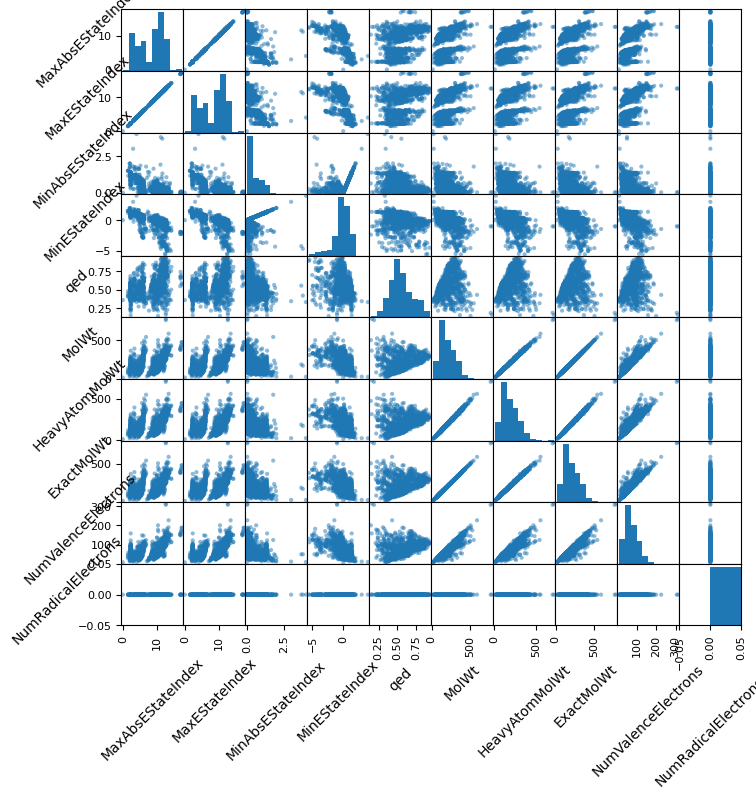

In [12]:
# 図1.1 (a)の作図
from pandas.plotting import scatter_matrix

sm = scatter_matrix(df_rdkit[TARGET], figsize=(8,8))

[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]

plt.savefig('./results/eda/rdkit_scatter_mat.png')
plt.show()

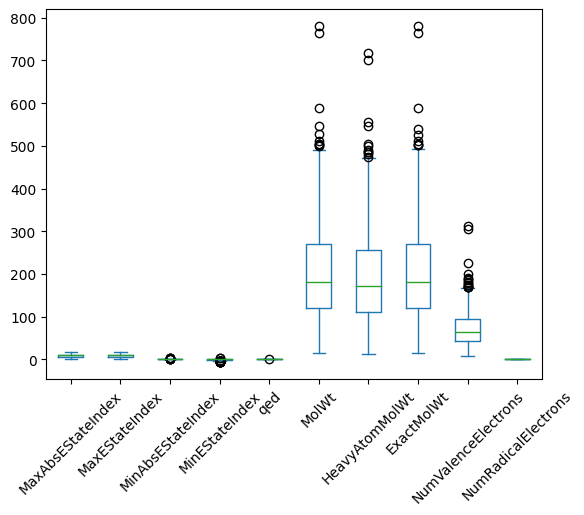

In [13]:
# 図1.1 (b)の作図
df_rdkit[TARGET].plot.box(rot=45)
plt.savefig('./results/eda/rdkit_box.png')

## ３.データの可視化　ー次元削減ー　（底本P12）

次元削減の意義と機械学習における活用方法や手法についてまとめます。

1. 次元削減の意義:
   - 高次元のデータにおいて、次元が増えるとデータの可視化や理解が困難になるため、次元削減は重要です。
   - 高次元のデータでは、冗長な情報やノイズが存在することが多く、次元削減によってこれらを取り除くことでデータの質を向上させることができます。
   - 次元削減によってデータの特徴を抽出し、計算の効率化や過学習の軽減など、機械学習モデルの性能向上に寄与することができます。  


2. 機械学習における次元削減の活用方法:
   - 特徴選択（Feature Selection）: 高次元の特徴空間から重要な特徴を選択し、それに基づいてモデルを構築することで、計算効率の向上やモデルの性能向上を図ります。
   - 特徴抽出（Feature Extraction）: 高次元のデータを低次元の新たな特徴空間に射影することで、データの表現を簡素化し、計算効率やモデルの性能向上を図ります。
   - データ可視化: 次元削減はデータの可視化にも利用されます。データを低次元に射影することで、データのクラスタリングや分布の構造を可視化し、洞察を得ることができます。


以下は、代表的な次元削減の手法である主成分分析（PCA）、t-SNE、UMAPの定義と活用方法を表形式でまとめたものです。

| 手法 | 　　線形性　　　 | 定義|
| :---: | :---: |:---: |
| 主成分分析（PCA） |　　線形　　| 元の多次元空間データの情報をできるだけ保持しつつ、<br>データの変動を最大限に捉える主成分空間への射影する手法  |
| t-SNE（t-Distributed Stochastic Neighbor Embedding）|　　 非線形　　　 | 高次元データを低次元空間に埋め込むことで、データ間の類似性や<br>クラスタ構造をできるだけ保持しつつ、可視化を行う手法。|
| UMAP（Uniform Manifold Approximation and Projection）|　　非線形　　　 | 高次元データを低次元のマニフォールド（滑らかな多様体）上に<br>確率的な近似に基づいて埋め込みの最適化を行う手法。|

### 作業の流れ
ここでは次元削減の例としてt-SNEを用いて、化合物の相関関係を見てみることにします。

1. 水溶解度のファイルをダウンロードする　（省略）
1. Morganフィンガープリントを0/1で256桁として取り出す
1. Morganフィンガープリントを基準にしてタニモト距離を計算する
1. タニモト距離を使ってt-SNEを学習させて可視化する

### ライブラリのインポート

In [14]:
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

半径3でビットベクトルのサイズ=256のMorgan Fingerprintを三項演算子の方法で計算し出力します。

In [15]:
X = np.matrix([GetMorganFingerprintAsBitVect(m, radius=3, nBits=256) for m in df['mol']])
X

matrix([[1, 1, 1, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]])

In [16]:
X.shape

(1128, 256)

### タニモト係数の計算　（分子の類似度計算）

タニモト係数は、化学構造の類似性を評価するための指標として広く使用される重要な指標です。タニモト係数は、化合物の構造を特徴付けるために使用されるバイナリフィンガープリント（Fingerprint）データを比較し、類似性を定量化するために利用されます。

ケモインフォマティクスでは、化合物の特性や活性を数値化するために、化学構造を分析し特徴を抽出します。その際、バイナリフィンガープリントは、化合物の構造情報をベクトル形式で表現する一般的な手法の一つです。バイナリフィンガープリントは、分子内の化学的パターンや環境情報を取得し、各パターンの存在を1または0のバイナリ値で表現します。

タニモト係数は、バイナリフィンガープリント同士の類似性を評価するために利用されます。2つの化合物のバイナリフィンガープリントを比較し、共通のフィンガープリントのビット数を分母に、2つのフィンガープリントのビットごとの共通の1の数を分子に用いて計算されます。タニモト係数は、0から1の範囲の値を取り、値が1に近いほど化合物の類似性が高いことを示します。

タニモト係数は、2つの集合の共通要素の数を、それぞれの集合の合計要素数に対して比較します。具体的には、2つの集合 `A` と `B` のタニモト係数は次のように計算されます：

```
Tanimoto coefficient = (|A ∩ B|) / (|A| + |B| - |A ∩ B|)
```

ここで、`|A|` は集合 `A` の要素数、`|B|` は集合 `B` の要素数、`|A ∩ B|` は2つの集合の共通要素の数を表します。タニモト係数は、0から1の値を取り、値が1に近いほど2つの集合は類似していることを示します。


一方、似た指標としてジャカード距離（Jaccard distance）があります。ジャカード距離は、2つの集合の共通要素の数を、それぞれの集合の合計要素数から差し引いた値を、それぞれの集合の合計要素数で割って計算します。ジャカード距離は次のように表されます：

```
Jaccard distance = 1 - (|A ∩ B|) / (|A| + |B| - |A ∩ B|)
```

ジャカード距離は、0から1の範囲の値を取り、値が0に近いほど2つの集合は類似していることを示します。

なお、ケモインフォマテックスではタニモト距離として次のような定義がありますので、ジャカード距離とタニモト距離は同義です。

```
Tanimoto distance = 1 - Tanimoto coefficient
```

このように、タニモト係数とジャカード距離（タニモト距離）は、1から他の値を引いたもので表現されるため、互いに対応関係にあります。

これより、タニモト係数とジャカード距離は、共通の要素を持つ2つの集合の類似性を測定する際に使用される類似度指標です。タニモト係数は類似度を示し、値が1に近いほど類似性が高いことを示します。ジャカード距離は距離を示し、値が0に近いほど類似性が高いことを示します。両者は相補的な関係にあり、一方の値を計算すれば他方の値を推定することも可能です。

タニモト係数は、化合物の類似性検索、バーチャルスクリーニング、クラスタリング、ヒット拡張など、さまざまなケモインフォマティクスの応用において重要な役割を果たします。化合物の類似性評価は、新規のバイオアクティブな化合物の発見やリード最適化、薬物デザインなどの分野で重要な要素です。タニモト係数は、化学的な特徴を捉え、バイナリフィンガープリントを用いて大規模な化合物データベースの探索や分析を効率的に行うために不可欠なツールとなっています。

In [17]:
from scipy.spatial.distance import pdist, squareform

distances = pdist(X, metric='jaccard')

# 距離ベクトルを元の行列形式に変換
D = squareform(distances)
D.shape

(1128, 1128)

【解説】scipyを用いた様々な距離の計算方法
* `scipy.spatial.distance`モジュールから`pdist`と`squareform`をインポートすることで、データセット内のデータポイント間の距離を計算する機能を利用することができます。

* `pdist`関数は、与えられたデータセット内のデータポイント間の距離を計算します。データセットは通常、2次元または多次元の配列として表され、各行が個々のデータポイントを表します。距離計算には、さまざまな距離尺度（ユークリッド距離、マンハッタン距離、コサイン距離、ジャカード距離など）を使用することができます。`pdist`関数は、計算された距離を圧縮したベクトル形式で返します。

* `squareform`関数は、`pdist`関数によって得られた距離ベクトルを元の行列形式に変換します。具体的には、距離ベクトルを対称行列に変換します。この行列は、元のデータセット内の各データポイントの間の距離を表現します。対称行列の要素は、元のデータセットの対応するデータポイント間の距離に対応しています。


* 以下は、`pdist`と`squareform`を使用してデータセット内のデータポイント間の距離行列を計算し、それを元の行列形式に変換する一般的な使用例です。

```python
from scipy.spatial.distance import pdist, squareform

# データセットの準備
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# データポイント間の距離行列を計算
distances = pdist(data, metric='euclidean')

# 距離ベクトルを元の行列形式に変換
distance_matrix = squareform(distances)
```

このようにすることで、`distance_matrix`は元のデータセットのデータポイント間の距離行列を表します。

In [18]:
D

array([[0.        , 0.8125    , 0.86486486, ..., 0.91139241, 0.95384615,
        0.8988764 ],
       [0.8125    , 0.        , 0.84313725, ..., 0.92982456, 0.97619048,
        0.80327869],
       [0.86486486, 0.84313725, 0.        , ..., 0.91304348, 0.89655172,
        0.89285714],
       ...,
       [0.91139241, 0.92982456, 0.91304348, ..., 0.        , 0.86666667,
        0.87719298],
       [0.95384615, 0.97619048, 0.89655172, ..., 0.86666667, 0.        ,
        0.97777778],
       [0.8988764 , 0.80327869, 0.89285714, ..., 0.87719298, 0.97777778,
        0.        ]])

### タニモト距離の可視化

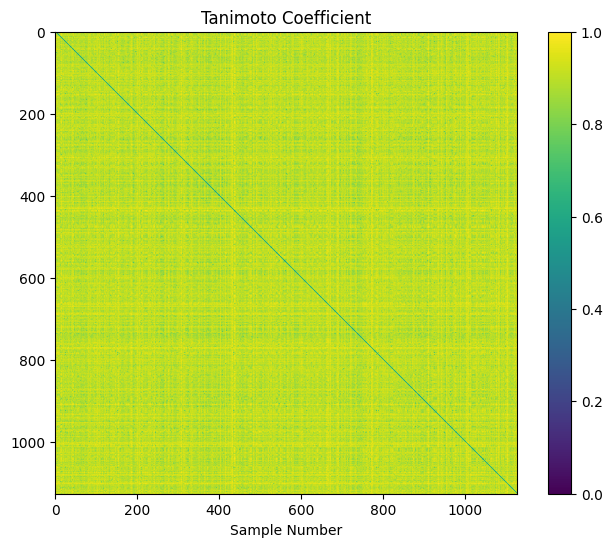

In [19]:
# 図1.4　タニモト距離を用いた化合物データの性状確認
# 図 1.4(a)　タニモト距離の可視化

fig = plt.subplots(figsize=(8, 6))
plt.imshow(D)
plt.colorbar()

plt.title('Tanimoto Coefficient')
plt.xlabel('Sample Number')

#plt.savefig('./results/eda/tanimotocoef.png')

plt.show()

## 化合物の類似性検索

参照分子との類似性を計算します。以下は、MorganのFingerprintを使用して`DataStructs`モジュールにある`FingerprintSimilarity`メソッドからタニモト距離を計算する例です。

ここでは、下記の化合物をDelaneyの1128の化合物の中からタニモト距離で最も類似性のある化合物を検索します。Morganフィンガープリントとして半径2としてセットします。

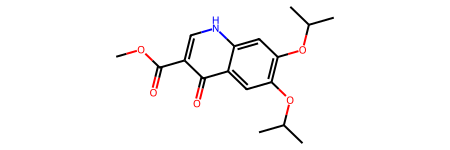

In [20]:
ref_smiles = 'COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O'
ref_mol = Chem.MolFromSmiles(ref_smiles)
ref_mol

In [21]:
ref_fps = AllChem.GetMorganFingerprintAsBitVect(ref_mol,2)
ref_fps

In [22]:
bulk_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2) for x in df['mol']]

三項演算子の方法を使って1128化合物とのタニモト距離を計算を総当たりに行い、得られた距離を'Tanimoto_Similarity'のカラム名で追加します。

In [23]:
from rdkit import DataStructs

similarity = [DataStructs.FingerprintSimilarity(ref_fps,x) for x in bulk_fps]
df['Tanimoto_Similarity'] = similarity

リスト上位8番目までの目的化合物とのタニモト距離を`PandasTools`で見てみましょう。

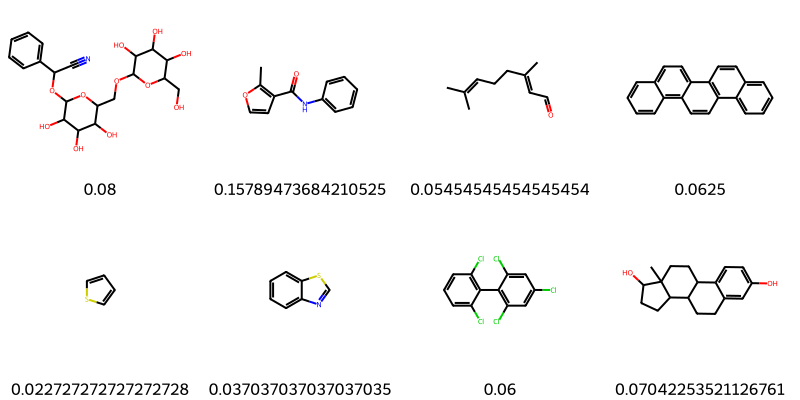

In [25]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')
PandasTools.FrameToGridImage(df.head(8), legendsCol="Tanimoto_Similarity", molsPerRow=4)

類似度を昇降順に並べると

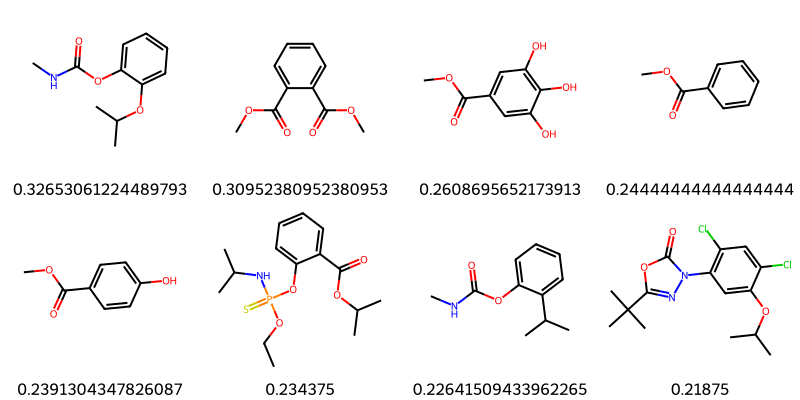

In [26]:
esol_data = df.sort_values(['Tanimoto_Similarity'], ascending=False)
PandasTools.FrameToGridImage(esol_data.head(8), legendsCol="Tanimoto_Similarity", molsPerRow=4)

【留意事項】  
タニモト距離を用いた化合物の類似度検索において、Fingerprintの選択は重要な要素となりますが、下記の留意すべき点があります。

1. フィンガープリントのタイプ:　タニモト距離を計算するためには、比較する化合物のFingerprintが同じタイプとします。異なるタイプのFingerprintを比較することはできません。

2. フィンガープリントのパラメータ:　Fingerprintの計算において、パラメータを変更すると、Fingerprintの特徴が変わり、類似度の計算結果にも影響を及ぼす可能性があります。

3. Fingerprintのビット長:　Fingerprintのビット長は、類似度検索の結果に大きな影響を与えます。ビット長が長い場合、より詳細な情報を持つFingerprintになりますが、計算コストも増加します。

4. 化合物データの特性:　使用するFingerprintの選択は、化合物データの特性に応じて検討する必要があります。例えば、特定のタイプの化合物ライブラリに対して最適なFingerprintが異なる場合があります。

5. フィンガープリントの比較方法:　タニモト距離はFingerprintの類似度を計算する方法の一つですが、他にも類似度指標があります（例：Tanimoto係数、Dice係数、コサイン類似度など）。使用するFingerprintに応じて、適切な類似度指標を選択する必要があります。

これらの留意点を考慮して、タニモト距離を用いた化合物の類似度検索を適切に行うためには、適切なFingerprintの選択とパラメータの調整が重要です。データセットや特定の化合物データに合わせて最適なFingerprintを選ぶことで、より有用な類似度検索結果を得ることができます。

### t-SNEによる次元削減

t-SNE（t分布型確率的近傍埋め込み法：t-Distributed Stochastic Neighbor Embedding）は、非線形な次元削減手法の一つ。


**特徴**  
t-SNEは、高次元データの視覚化や特徴の圧縮に使用されます。特に、データの局所的な類似性を維持しつつ、データ間のグローバルな関係を捉えることができる特徴があります。

t-SNEは、主に2つのステップから構成されます。まず、高次元データの類似度行列を作成します。この行列は、各データポイント間の類似度や距離を表現します。通常は、ユークリッド距離やコサイン類似度などが使用されます。

次に、類似度行列を元に、低次元空間への埋め込みを行います。この埋め込みでは、高次元データを2次元または3次元の低次元空間に変換します。この変換により、データのグローバルな構造やクラスタリングのパターンが視覚化されます。

**アルゴリズム**  
t-SNEは、データポイントの位置を定めるために確率的なアプローチを使用しており、データポイント間の類似度に基づいて確率分布を作成します。高次元データでは、近くにあるデータポイントの類似度が高いことが多いため、近くのデータポイント間の確率は高くなります。同様に、低次元空間でも近くにあるデータポイント間の確率が高いように調整されます。この確率分布の最適化には、確率的勾配降下法が使用されます。

**利点**  
t-SNEの利点は、特にデータの局所的な構造やクラスタリングの特徴を視覚的に表現できる点です。また、次元削減によってデータの可視化やクラスタリングの際に、有用な特徴を抽出することができます。

**制約**  
t-SNEにはいくつかの制約もあります。例えば、計算コストが高いため、大規模なデータセットでは時間がかかる場合があります。また、異なる実行ごとに結果が異なることがあるため、再現性に注意する必要があります。さらに、t-SNEは非線形次元削減手法であるため、高次元データのグローバルな構造を正確に反映しづらい場合があります。

【参照テクニカルノート】
https://orist.jp/content/files/22-14.pdf

In [70]:
# 図 1.4(b)　水溶解度データについてタニモト距離を元にt-SNEで次元削減した結果
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=66)
T = tsne.fit_transform(D)

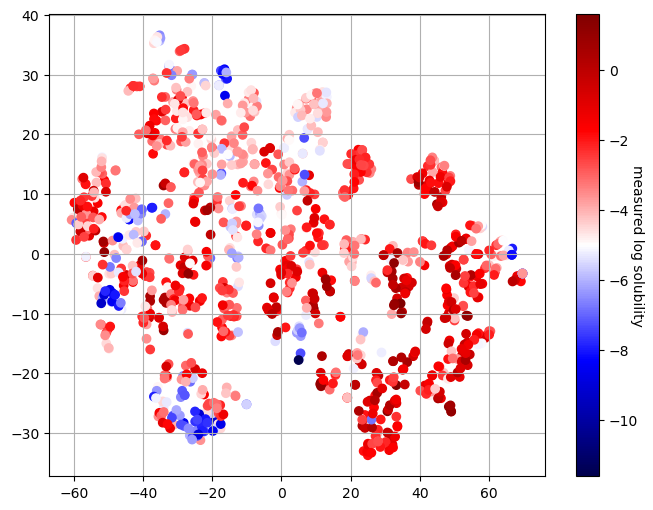

In [71]:
fig = plt.subplots(figsize=(8, 6))

y = df['measured log solubility in mols per litre'].values
plt.scatter(T[:,0],T[:,1], c=y, cmap=plt.cm.seismic)

cbar = plt.colorbar()
cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

### 【参考】PCAによる次元削減

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [73]:
pca = make_pipeline(StandardScaler(), PCA())
T_pca = pca.fit_transform(D)

In [74]:
ratio_ = dict(pca.steps)['pca'].explained_variance_ratio_
ratio_

array([2.75234016e-01, 1.27286284e-01, 6.93471605e-02, ...,
       3.90335275e-36, 3.81324554e-36, 1.68406024e-36])

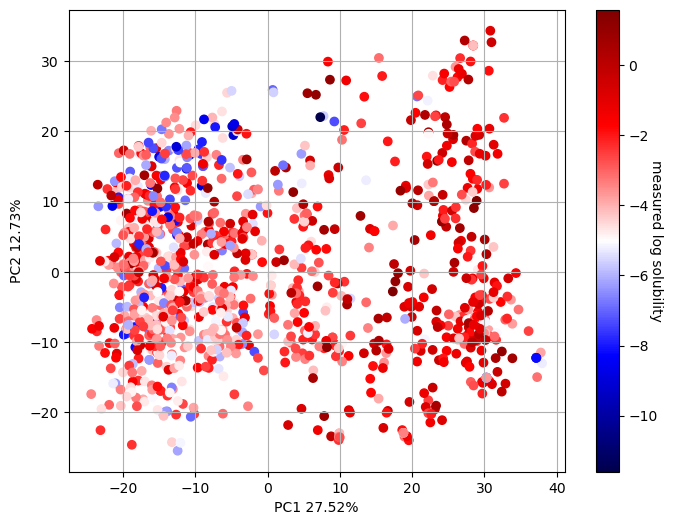

In [75]:
fig = plt.subplots(figsize=(8, 6))

y = df['measured log solubility in mols per litre'].values
plt.scatter(T_pca[:,0],T_pca[:,1], c=y, cmap=plt.cm.seismic)

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

cbar = plt.colorbar()
cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

## 考察例

1. Tanimoto係数で似ているとされている構造でも、log水溶解度は必ずしも近くならない
1. また、クラスターは特に出来ていないため、データを分ける必要はなさそう

# 次回  
https://colab.research.google.com/github/ARIM-Training/Training_python_4/blob/main/4_QSER.ipynb